## 1. Importação das Bibliotecas Necessárias



In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import silhouette_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, roc_curve,
    precision_recall_curve, average_precision_score, accuracy_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

from scipy import stats
from scipy.stats import wilcoxon, ttest_rel
import time
from collections import Counter

In [9]:
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 2. Carregamento dos dados

In [10]:
data_set = '/content/sample_data/creditcard.csv'
df = pd.read_csv(data_set)

2.1 Dimensão dos dados

In [11]:
print(f"Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas")

Dimensões: 284807 linhas × 31 colunas


2.2 Tipos de dados


In [12]:
print("\TIPOS DE DADOS:")
print(df.dtypes)

\TIPOS DE DADOS:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-2685792817.py:1: SyntaxWarning: invalid escape sequence '\T'
  print("\TIPOS DE DADOS:")


2.3 Primeiras linhas

In [13]:
print("\n PRIMEIRAS 5 LINHAS:")
display(df.head())


 PRIMEIRAS 5 LINHAS:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


2.4 Estatíticas descritivas dos dados

In [14]:
print("\n ESTATÍSTICAS DESCRITIVAS:")
display(df.describe())


 ESTATÍSTICAS DESCRITIVAS:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


2.5 Remoção de duplicatas

In [15]:
initial_len = df.shape[0]
df = df.drop_duplicates()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartadas {initial_len - df.shape[0]} duplicadas')

Tamanho inicial: 284807, tamanho final 283726 | Descartadas 1081 duplicadas


2.6 Missing values

In [16]:
initial_len = df.shape[0]
df = df.dropna()
print(f'Tamanho inicial: {initial_len}, tamanho final {df.shape[0]} | Descartados {initial_len - df.shape[0]} registros com valores NA')

Tamanho inicial: 283726, tamanho final 283726 | Descartados 0 registros com valores NA


2.7 Distribuição de classes

In [17]:
print(f"\nDistribuição da Classe Target (Class):")
print(df['Class'].value_counts())
print(f"\n   Proporção de Fraudes: {df['Class'].mean()*100:.4f}%")


Distribuição da Classe Target (Class):
Class
0    283253
1       473
Name: count, dtype: int64

   Proporção de Fraudes: 0.1667%


# 3. Análise Exploratória de Dados

3.1 Análise do Desbalanceamento de Classes

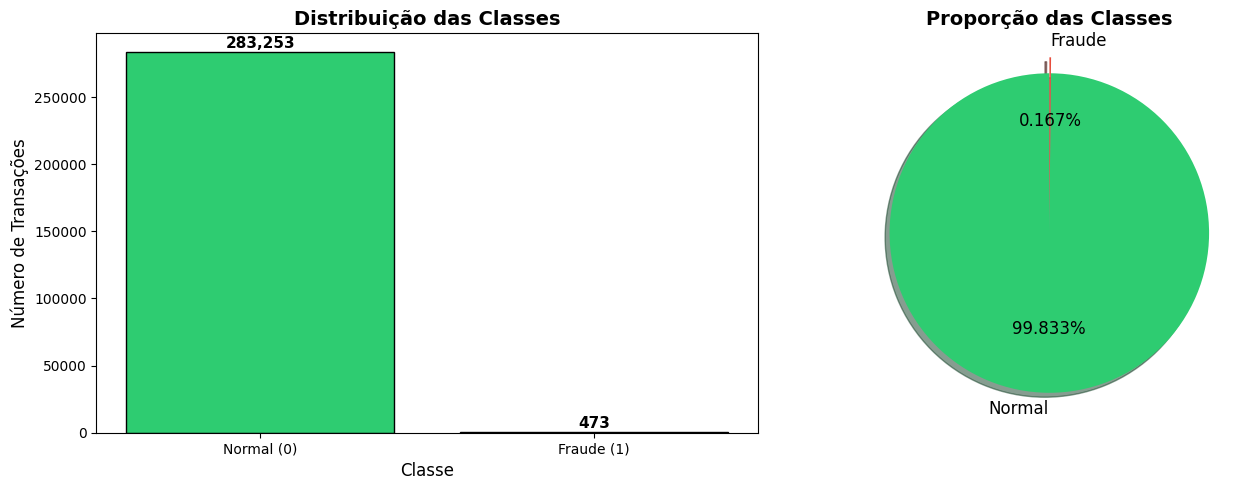

ANÁLISE DO DESBALANCEAMENTO

Transações Normais: 283,253 (99.833%)
Transações Fraudulentas: 473 (0.167%)
Razão de Desbalanceamento: 1:598


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts = df['Class'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['Normal (0)', 'Fraude (1)'], class_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Distribuição das Classes', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Número de Transações', fontsize=12)
axes[0].set_xlabel('Classe', fontsize=12)

for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                 f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

explode = (0, 0.1)
axes[1].pie(class_counts.values, explode=explode, labels=['Normal', 'Fraude'],
            colors=colors, autopct='%1.3f%%', shadow=True, startangle=90,
            textprops={'fontsize': 12})
axes[1].set_title('Proporção das Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("ANÁLISE DO DESBALANCEAMENTO")
fraud_count = df[df['Class'] == 1].shape[0]
normal_count = df[df['Class'] == 0].shape[0]
print(f"\nTransações Normais: {normal_count:,} ({normal_count/len(df)*100:.3f}%)")
print(f"Transações Fraudulentas: {fraud_count:,} ({fraud_count/len(df)*100:.3f}%)")
print(f"Razão de Desbalanceamento: 1:{normal_count//fraud_count}")

 3.2 Análise das Features Time e Amount

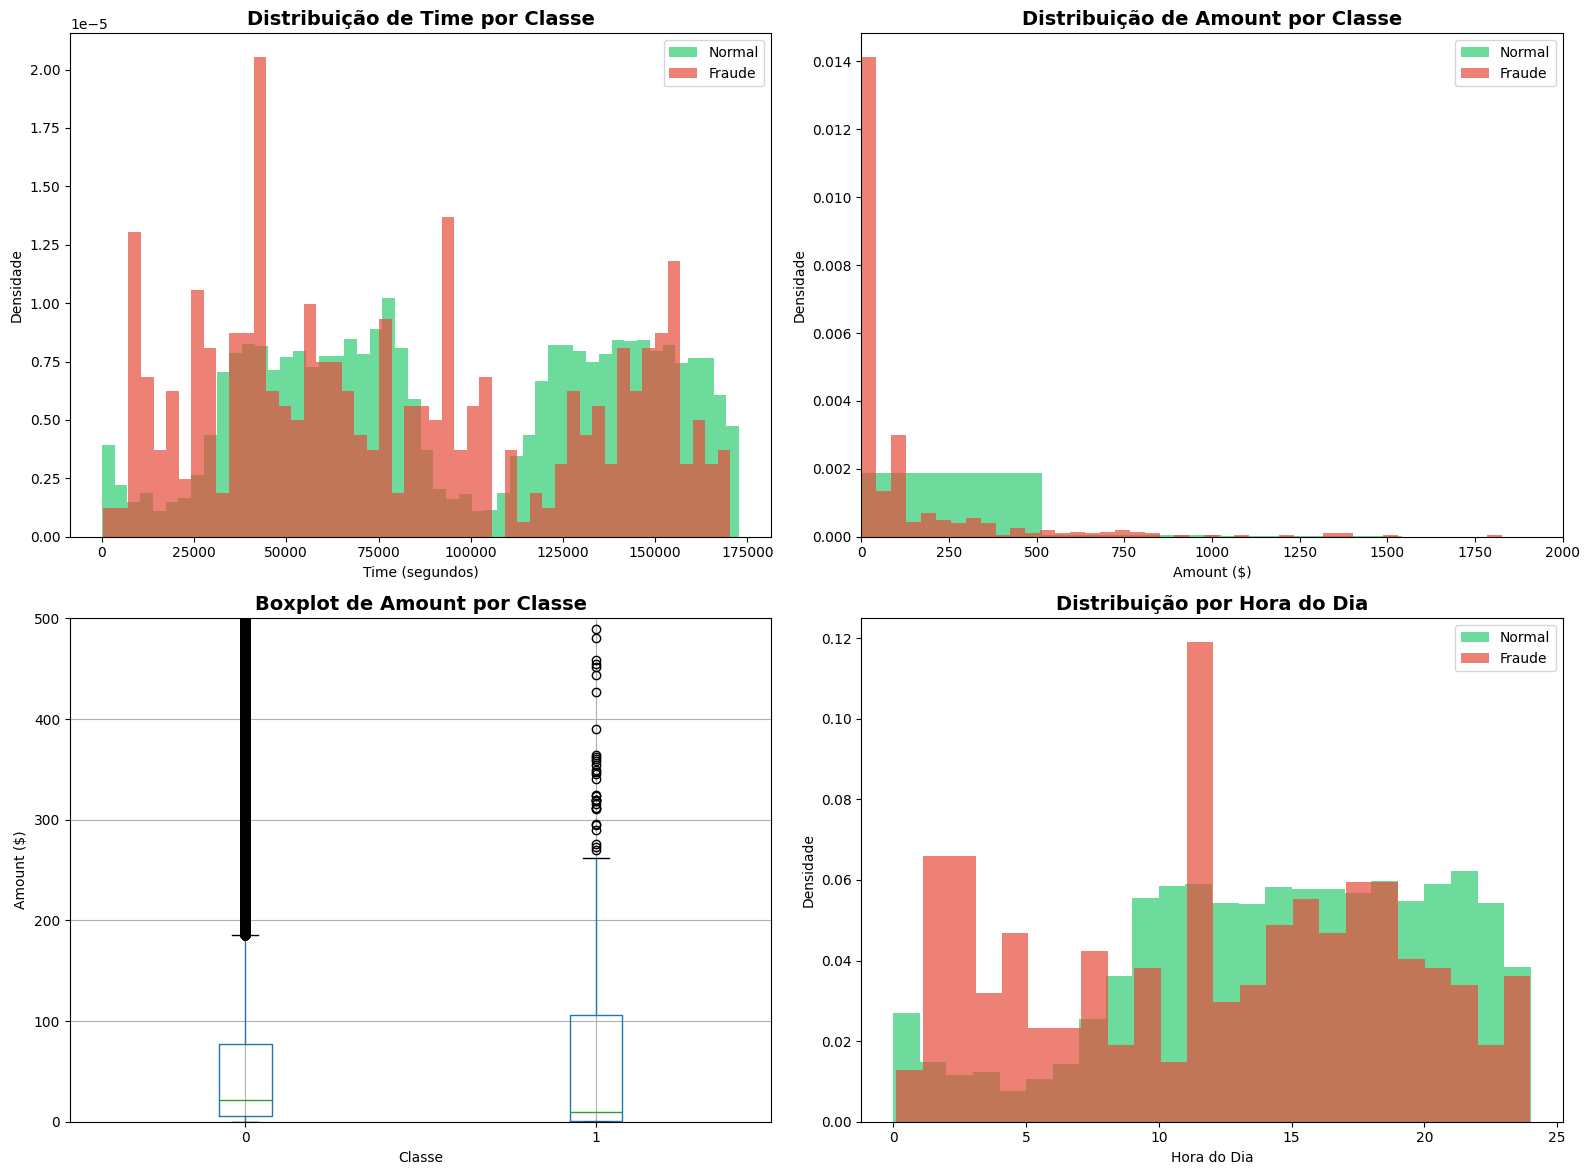

ESTATÍSTICAS DE TIME E AMOUNT

Amount - Transações Normais:
   Média: $88.41
   Mediana: $22.00
   Desvio Padrão: $250.38
   Máximo: $25691.16

Amount - Transações Fraudulentas:
   Média: $123.87
   Mediana: $9.82
   Desvio Padrão: $260.21
   Máximo: $2125.87


In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

fraud_df = df[df['Class'] == 1]
normal_df = df[df['Class'] == 0]

axes[0, 0].hist(normal_df['Time'], bins=50, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[0, 0].hist(fraud_df['Time'], bins=50, alpha=0.7, label='Fraude', color='#e74c3c', density=True)
axes[0, 0].set_title('Distribuição de Time por Classe', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time (segundos)')
axes[0, 0].set_ylabel('Densidade')
axes[0, 0].legend()

axes[0, 1].hist(normal_df['Amount'], bins=50, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[0, 1].hist(fraud_df['Amount'], bins=50, alpha=0.7, label='Fraude', color='#e74c3c', density=True)
axes[0, 1].set_title('Distribuição de Amount por Classe', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Amount ($)')
axes[0, 1].set_ylabel('Densidade')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 2000)

df.boxplot(column='Amount', by='Class', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot de Amount por Classe', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Classe')
axes[1, 0].set_ylabel('Amount ($)')
axes[1, 0].set_ylim(0, 500)
plt.suptitle('')

df['Hour'] = (df['Time'] / 3600) % 24
fraud_hours = df[df['Class'] == 1]['Hour']
normal_hours = df[df['Class'] == 0]['Hour']

axes[1, 1].hist(normal_hours, bins=24, alpha=0.7, label='Normal', color='#2ecc71', density=True)
axes[1, 1].hist(fraud_hours, bins=24, alpha=0.7, label='Fraude', color='#e74c3c', density=True)
axes[1, 1].set_title('Distribuição por Hora do Dia', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hora do Dia')
axes[1, 1].set_ylabel('Densidade')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('time_amount_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("ESTATÍSTICAS DE TIME E AMOUNT")
print("\nAmount - Transações Normais:")
print(f"   Média: ${normal_df['Amount'].mean():.2f}")
print(f"   Mediana: ${normal_df['Amount'].median():.2f}")
print(f"   Desvio Padrão: ${normal_df['Amount'].std():.2f}")
print(f"   Máximo: ${normal_df['Amount'].max():.2f}")

print("\nAmount - Transações Fraudulentas:")
print(f"   Média: ${fraud_df['Amount'].mean():.2f}")
print(f"   Mediana: ${fraud_df['Amount'].median():.2f}")
print(f"   Desvio Padrão: ${fraud_df['Amount'].std():.2f}")
print(f"   Máximo: ${fraud_df['Amount'].max():.2f}")

3.3 Análise das Features PCA (V1-V28)

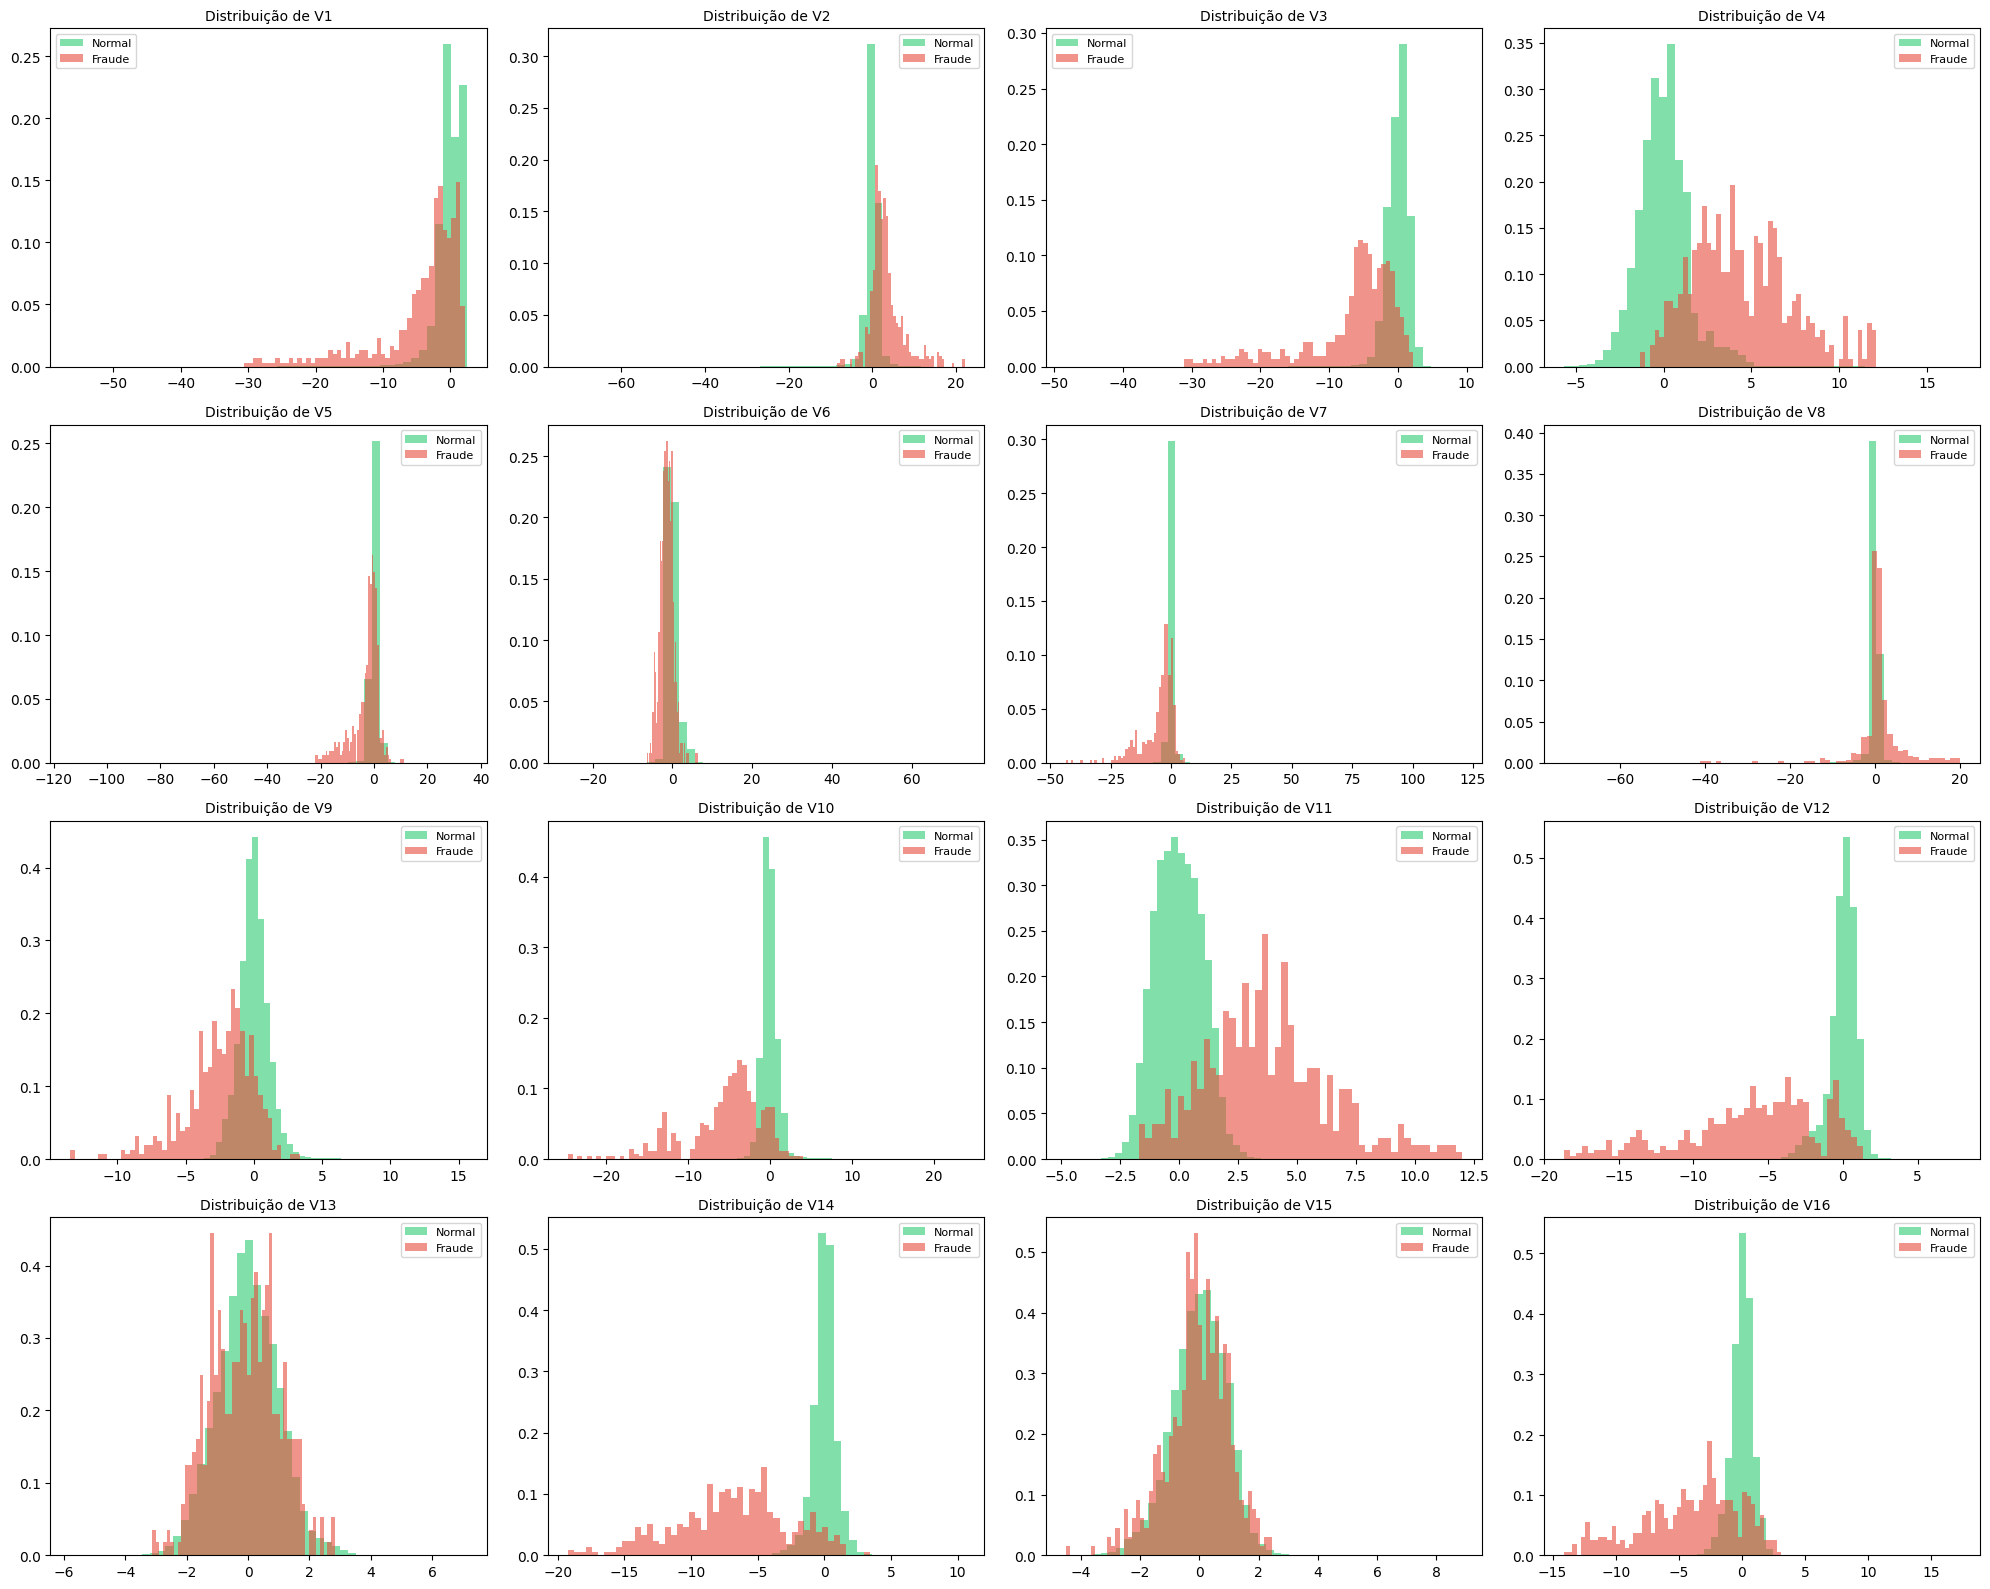

In [20]:
v_features = [f'V{i}' for i in range(1, 29)]

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, feature in enumerate(v_features[:16]):
    axes[i].hist(normal_df[feature], bins=50, alpha=0.6, label='Normal', color='#2ecc71', density=True)
    axes[i].hist(fraud_df[feature], bins=50, alpha=0.6, label='Fraude', color='#e74c3c', density=True)
    axes[i].set_title(f'Distribuição de {feature}', fontsize=10)
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.savefig('v_features_distribution_1.png', dpi=150, bbox_inches='tight')
plt.show()

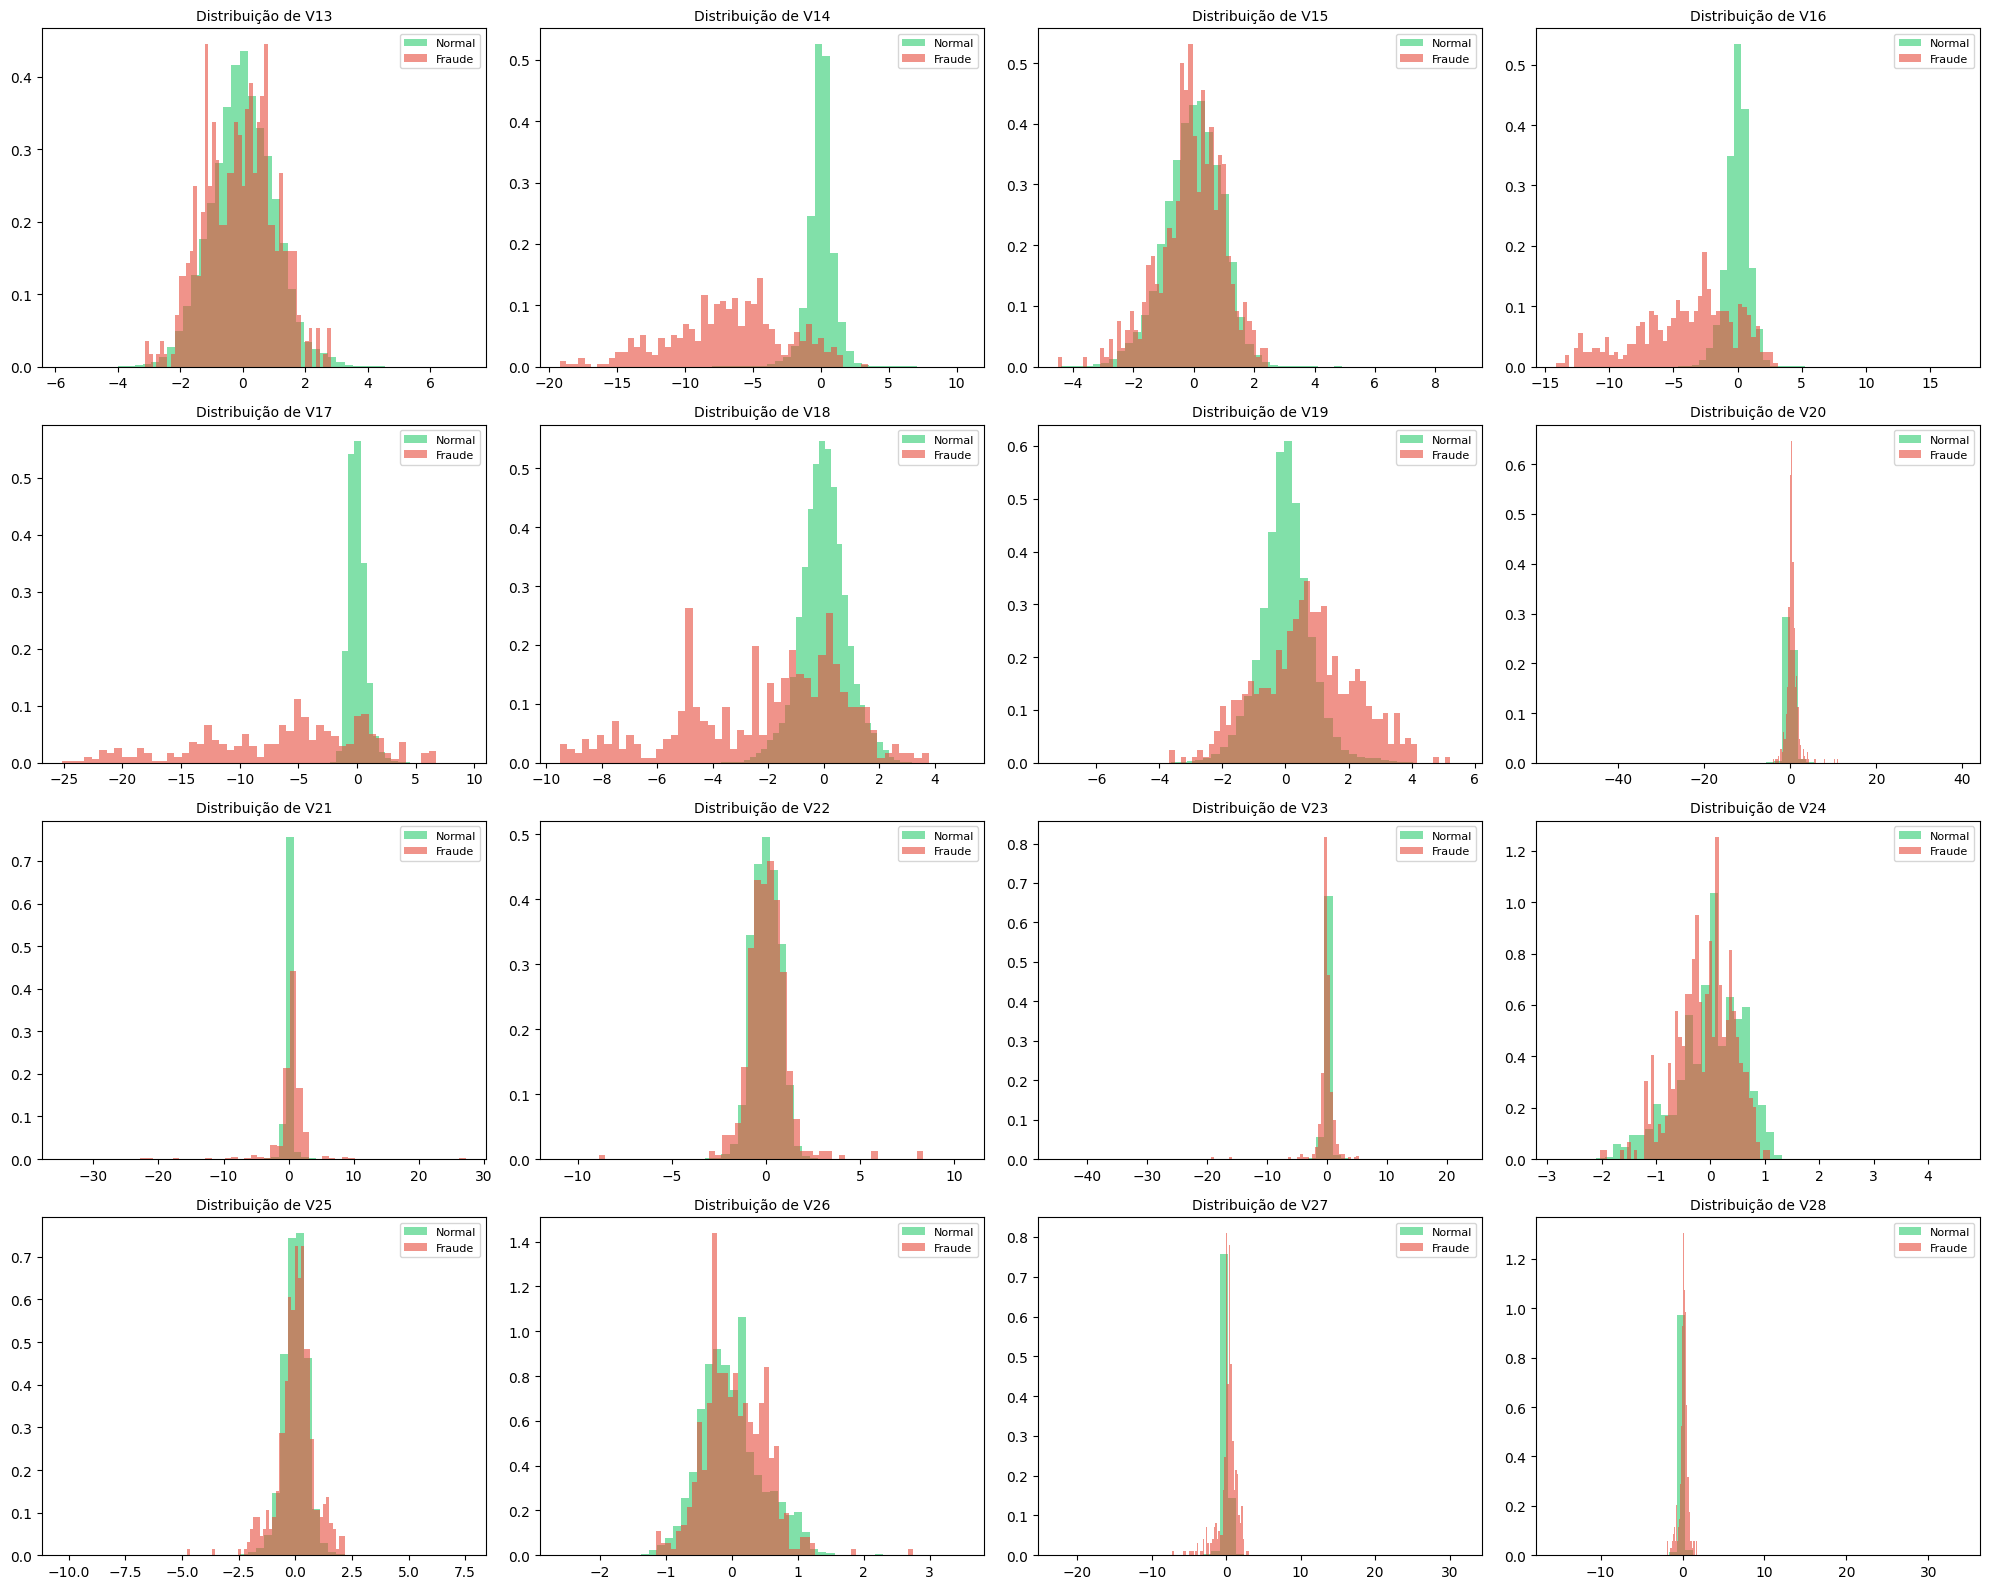

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, feature in enumerate(v_features[12:28]):
    axes[i].hist(normal_df[feature], bins=50, alpha=0.6, label='Normal', color='#2ecc71', density=True)
    axes[i].hist(fraud_df[feature], bins=50, alpha=0.6, label='Fraude', color='#e74c3c', density=True)
    axes[i].set_title(f'Distribuição de {feature}', fontsize=10)
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.savefig('v_features_distribution_2.png', dpi=150, bbox_inches='tight')
plt.show()

3.4 Matriz de Correlação

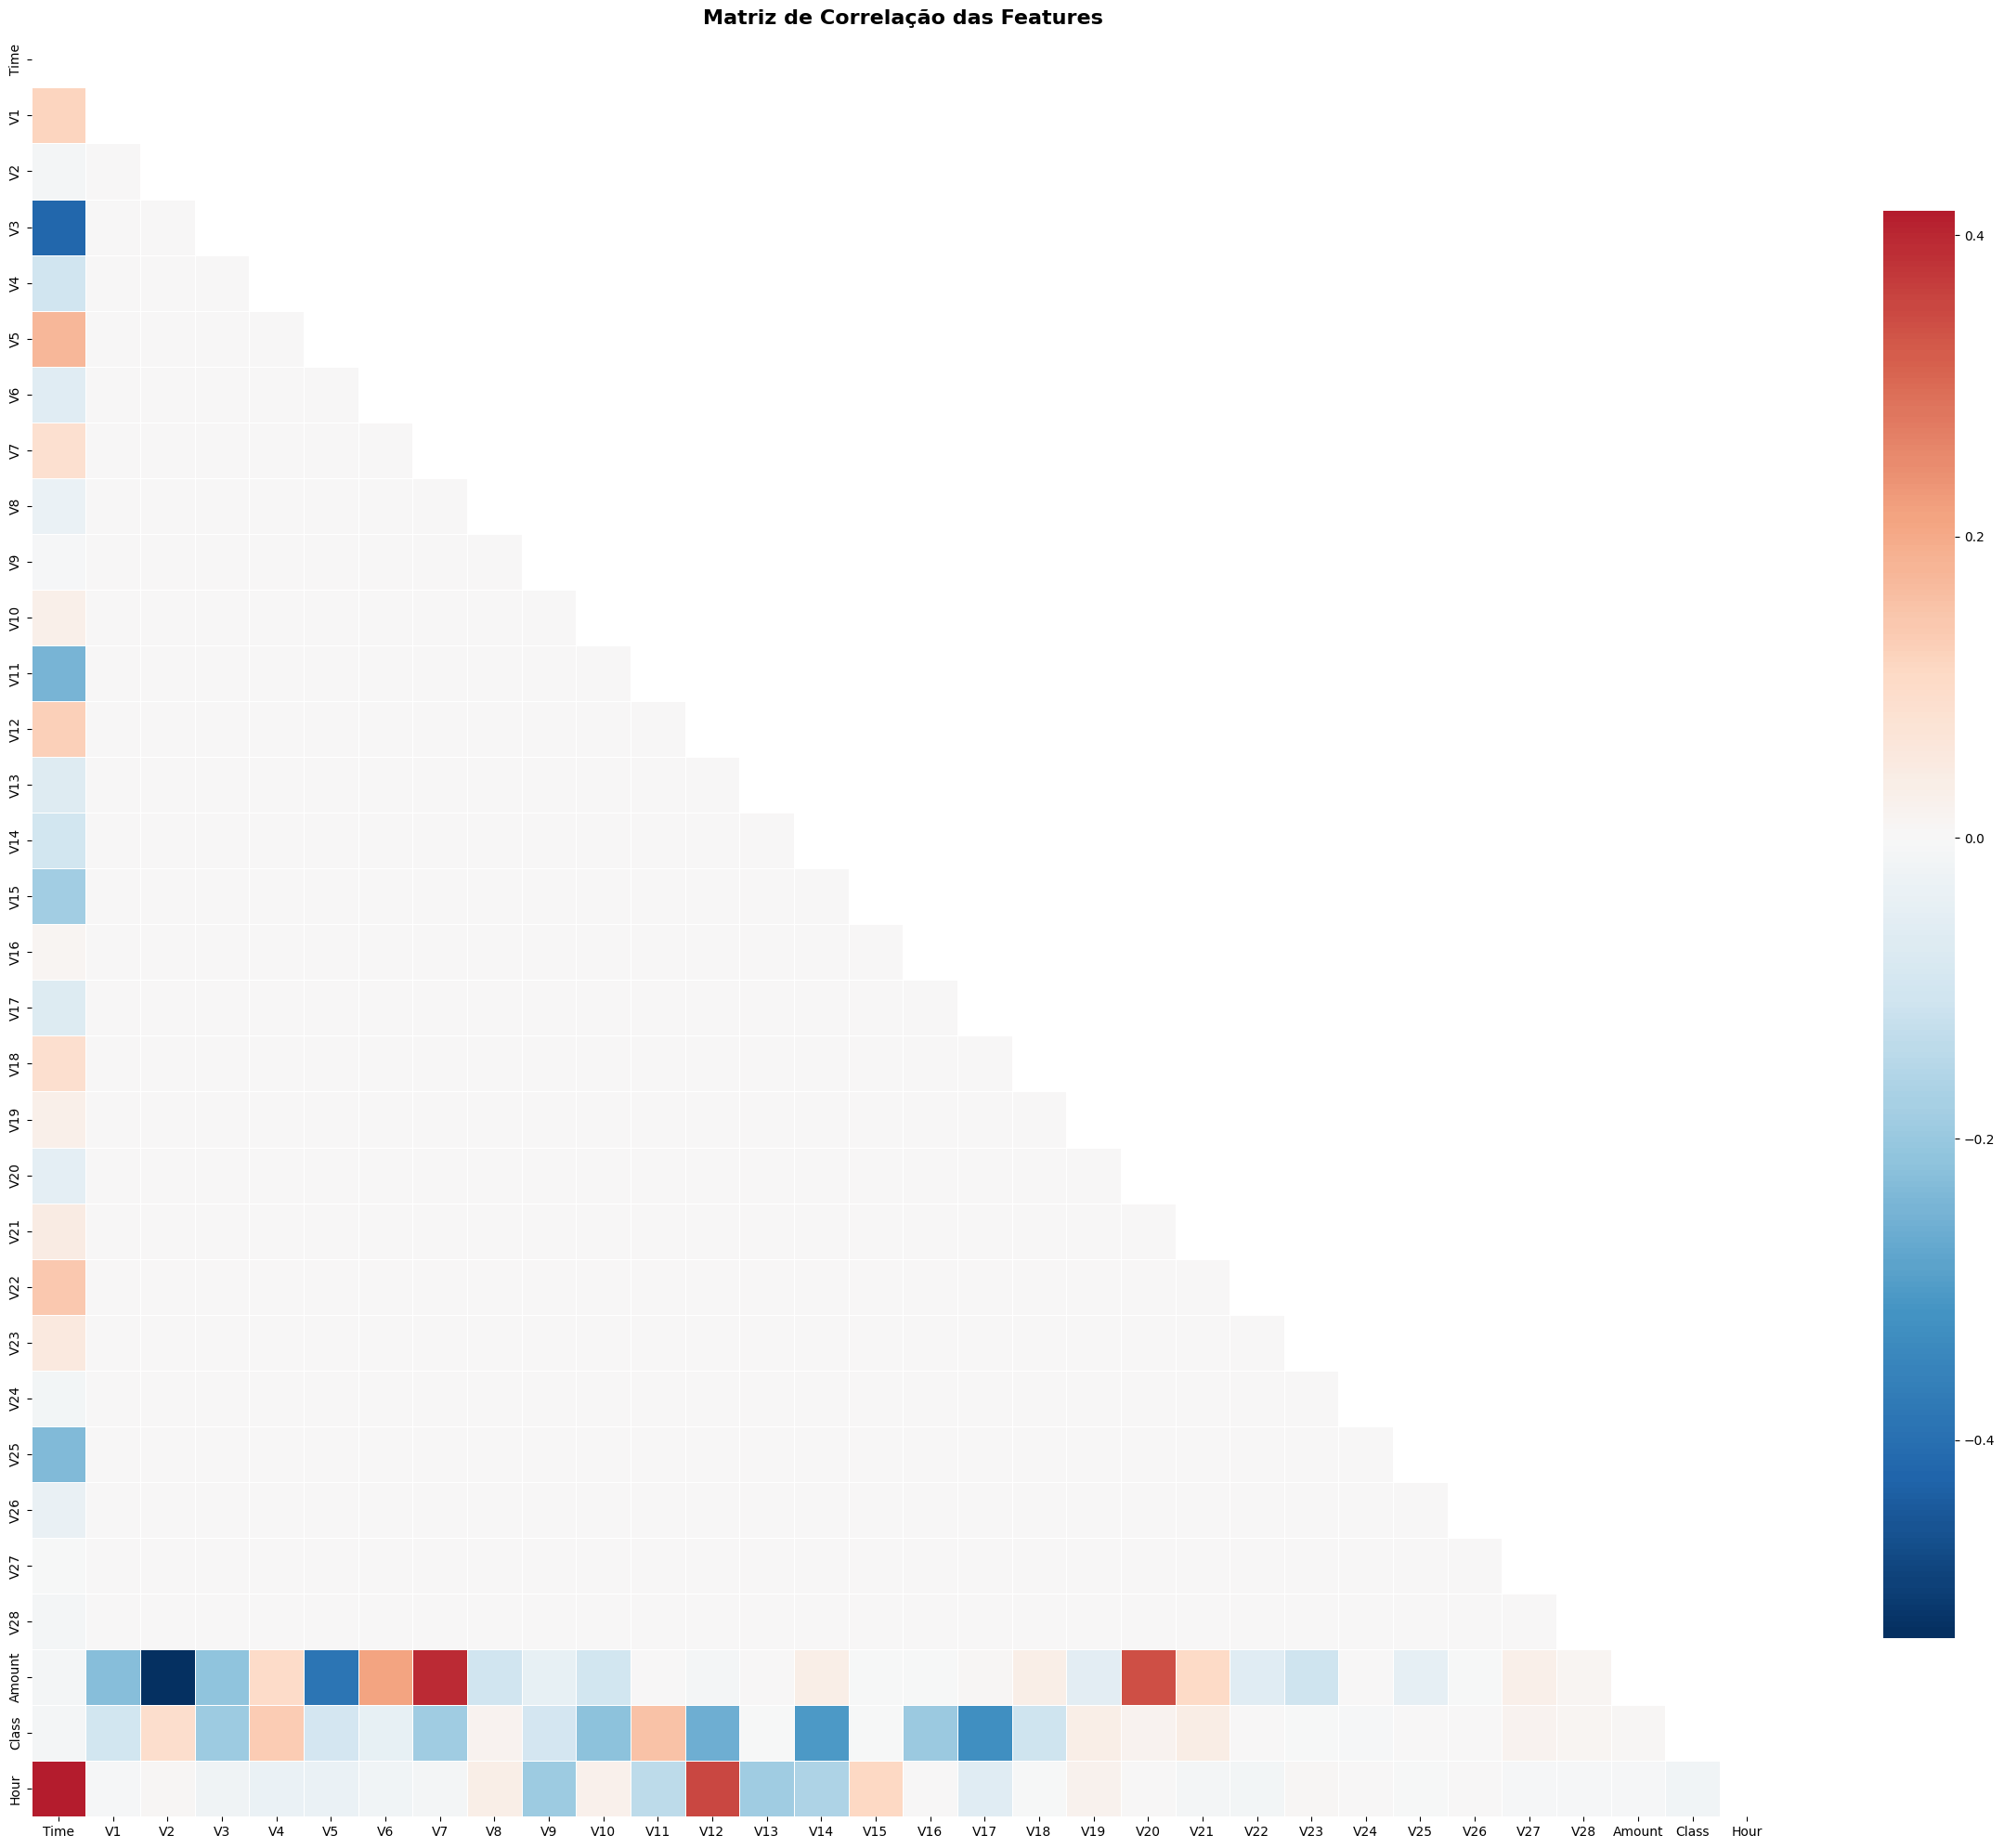

CORRELAÇÃO DAS FEATURES COM A CLASSE TARGET

Top 10 correlações mais fortes (em valor absoluto):
V17   -0.326481
V14   -0.302544
V12   -0.260593
V10   -0.216883
V16   -0.196539
V3    -0.192961
V7    -0.187257
V11    0.154876
V4     0.133447
V18   -0.111485
Name: Class, dtype: float64

Top 10 correlações mais fracas:
Time     -0.012323
V28       0.009536
V24      -0.007221
Amount    0.005632
V13      -0.004570
V26       0.004455
V15      -0.004223
V25       0.003308
V23      -0.002685
V22       0.000805
Name: Class, dtype: float64


In [23]:
plt.figure(figsize=(24, 20))
correlation_matrix = df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdBu_r',
            center=0, linewidths=0.5, fmt='.2f',
            cbar_kws={'shrink': 0.8})
plt.title('Matriz de Correlação das Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("CORRELAÇÃO DAS FEATURES COM A CLASSE TARGET")
correlations_with_class = df.corr()['Class'].drop('Class').sort_values(key=abs, ascending=False)
print("\nTop 10 correlações mais fortes (em valor absoluto):")
print(correlations_with_class.head(10))
print("\nTop 10 correlações mais fracas:")
print(correlations_with_class.tail(10))

# 4. Pré-processamento de dados


4.1 Normalização das features Time e Amount

In [22]:
df_processed = df.copy()

if 'Hour' in df_processed.columns:
    df_processed = df_processed.drop('Hour', axis=1)

robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

df_processed['Amount_scaled'] = robust_scaler.fit_transform(df_processed['Amount'].values.reshape(-1, 1))

df_processed['Time_scaled'] = standard_scaler.fit_transform(df_processed['Time'].values.reshape(-1, 1))

df_processed = df_processed.drop(['Time', 'Amount'], axis=1)

print("Normalização concluída!")
print(f"\nShape do dataset processado: {df_processed.shape}")
print(f"\nColunas após pré-processamento:")
print(df_processed.columns.tolist())

Normalização concluída!

Shape do dataset processado: (283726, 31)

Colunas após pré-processamento:
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Amount_scaled', 'Time_scaled']


4.2 Separação dos Dados em Treino, Validação e Teste

Utilizaremos a seguinte divisão:
*   Treino: 70% dos dados
*   Validação: 15% dos dados
*   Teste: 15% dos dados

Para detecção de anomalias em abordagem não supervisionada, treinaremos os modelos apenas com transações normais.

In [23]:
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_SEED, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_SEED, stratify=y_temp
)

print("DIVISÃO DOS DADOS")

print(f"\nConjunto de TREINO:")
print(f"   Total: {len(X_train):,} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Normal: {(y_train == 0).sum():,}")
print(f"   Fraude: {(y_train == 1).sum():,}")

print(f"\nConjunto de VALIDAÇÃO:")
print(f"   Total: {len(X_val):,} amostras ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Normal: {(y_val == 0).sum():,}")
print(f"   Fraude: {(y_val == 1).sum():,}")

print(f"\nConjunto de TESTE:")
print(f"   Total: {len(X_test):,} amostras ({len(X_test)/len(X)*100:.1f}%)")
print(f"   Normal: {(y_test == 0).sum():,}")
print(f"   Fraude: {(y_test == 1).sum():,}")

DIVISÃO DOS DADOS

Conjunto de TREINO:
   Total: 198,608 amostras (70.0%)
   Normal: 198,277
   Fraude: 331

Conjunto de VALIDAÇÃO:
   Total: 42,559 amostras (15.0%)
   Normal: 42,488
   Fraude: 71

Conjunto de TESTE:
   Total: 42,559 amostras (15.0%)
   Normal: 42,488
   Fraude: 71


In [24]:
X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]


print("CONJUNTO DE TREINO PARA ABORDAGEM NÃO SUPERVISIONADA")

print(f"\nTreino apenas com transações NORMAIS:")
print(f"   Total: {len(X_train_normal):,} amostras")
print(f"   (Usaremos este conjunto para treinar os modelos de anomalia)")

CONJUNTO DE TREINO PARA ABORDAGEM NÃO SUPERVISIONADA

Treino apenas com transações NORMAIS:
   Total: 198,277 amostras
   (Usaremos este conjunto para treinar os modelos de anomalia)


# 5. Modelagem

5.1 Cálculo de métricas

In [25]:
def evaluate_model(y_true, y_pred, y_scores=None, model_name="Model"):
    metrics = {
        'Model': model_name,
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
    }

    if y_scores is not None:
        metrics['AUC-ROC'] = roc_auc_score(y_true, y_scores)
        metrics['AUC-PR'] = average_precision_score(y_true, y_scores)

    return metrics


def plot_confusion_matrix(y_true, y_pred, model_name="Model", ax=None):
    cm = confusion_matrix(y_true, y_pred)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Normal', 'Fraude'],
                yticklabels=['Normal', 'Fraude'])
    ax.set_xlabel('Predito')
    ax.set_ylabel('Real')
    ax.set_title(f'Matriz de Confusão - {model_name}')

    return cm


def print_metrics(metrics):
    print(f"MÉTRICAS - {metrics['Model']}")
    print(f"  Precisão:  {metrics['Precision']:.4f}")
    print(f"  Recall:    {metrics['Recall']:.4f}")
    print(f"  F1-Score:  {metrics['F1-Score']:.4f}")
    if 'AUC-ROC' in metrics:
        print(f"  AUC-ROC:   {metrics['AUC-ROC']:.4f}")
    if 'AUC-PR' in metrics:
        print(f"  AUC-PR:    {metrics['AUC-PR']:.4f}")

all_results = {}
all_predictions = {}
all_scores = {}
all_times = {}

5.2 Isolation Forest

Taxa de contaminação esperada: 0.0017 (0.17%)

TREINAMENTO - ISOLATION FOREST
Modelo treinado em 1.54 segundos
Tempo de inferência (validação): 0.50 segundos
MÉTRICAS - Isolation Forest
  Precisão:  0.1744
  Recall:    0.2113
  F1-Score:  0.1911
  AUC-ROC:   0.9381
  AUC-PR:    0.1119


<Figure size 800x600 with 0 Axes>

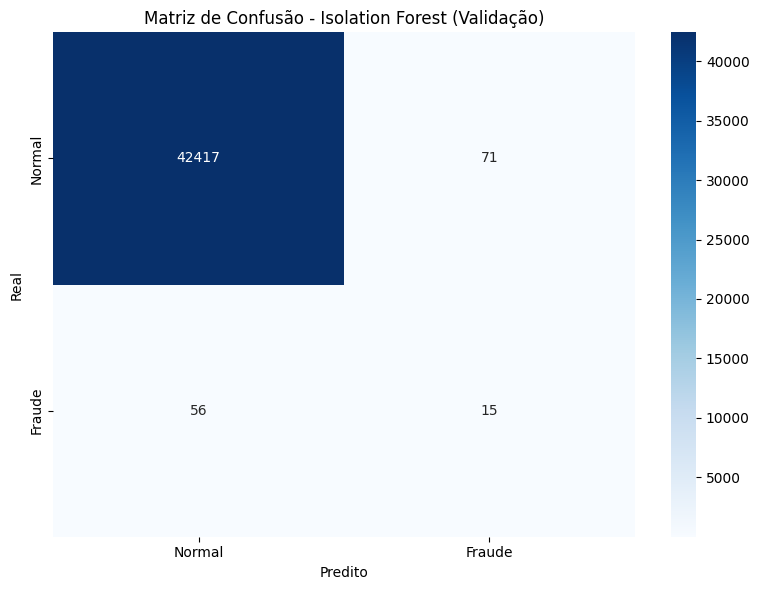

In [26]:
contamination_rate = y_val.mean()
print(f"Taxa de contaminação esperada: {contamination_rate:.4f} ({contamination_rate*100:.2f}%)")

print("\n" + "=" * 60)
print("TREINAMENTO - ISOLATION FOREST")
print("=" * 60)

if_params = {
    'n_estimators': 100,
    'contamination': contamination_rate,
    'max_samples': 'auto',
    'random_state': 42,
    'n_jobs': -1
}

start_time = time.time()
iso_forest = IsolationForest(**if_params)
iso_forest.fit(X_train_normal)
train_time_if = time.time() - start_time

print(f"Modelo treinado em {train_time_if:.2f} segundos")

start_time = time.time()
if_val_pred_raw = iso_forest.predict(X_val)
if_val_pred = np.where(if_val_pred_raw == -1, 1, 0)
if_val_scores = -iso_forest.score_samples(X_val)
inference_time_if_val = time.time() - start_time

print(f"Tempo de inferência (validação): {inference_time_if_val:.2f} segundos")

if_val_metrics = evaluate_model(y_val, if_val_pred, if_val_scores, "Isolation Forest")
print_metrics(if_val_metrics)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_val, if_val_pred, "Isolation Forest (Validação)")
plt.tight_layout()
plt.savefig('confusion_matrix_if_val.png', dpi=150, bbox_inches='tight')
plt.show()

5.2.1 Tunagem de hiperparâmetros

In [27]:
print("TUNAGEM DE HIPERPARÂMETROS - ISOLATION FOREST")

n_estimators_list = [50, 100, 200]
max_samples_list = [256, 512, 'auto']
contamination_list = [0.001, 0.002, 0.005, contamination_rate]

best_if_score = 0
best_if_params = {}
if_tuning_results = []

for n_est in n_estimators_list:
    for max_samp in max_samples_list:
        for contam in contamination_list:
            try:
                model = IsolationForest(
                    n_estimators=n_est,
                    max_samples=max_samp,
                    contamination=contam,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train_normal)

                pred_raw = model.predict(X_val)
                pred = np.where(pred_raw == -1, 1, 0)
                scores = -model.score_samples(X_val)

                f1 = f1_score(y_val, pred, zero_division=0)
                auc = roc_auc_score(y_val, scores)

                if_tuning_results.append({
                    'n_estimators': n_est,
                    'max_samples': max_samp,
                    'contamination': contam,
                    'F1-Score': f1,
                    'AUC-ROC': auc
                })

                if f1 > best_if_score:
                    best_if_score = f1
                    best_if_params = {
                        'n_estimators': n_est,
                        'max_samples': max_samp,
                        'contamination': contam
                    }
            except Exception as e:
                print(f"Erro com params {n_est}, {max_samp}, {contam}: {e}")

if_tuning_df = pd.DataFrame(if_tuning_results).sort_values('F1-Score', ascending=False)
print("\nTop 10 combinações de hiperparâmetros:")
print(if_tuning_df.head(10).to_string(index=False))

print(f"\nMelhores hiperparâmetros encontrados:")
print(f"   n_estimators: {best_if_params['n_estimators']}")
print(f"   max_samples: {best_if_params['max_samples']}")
print(f"   contamination: {best_if_params['contamination']}")
print(f"   F1-Score: {best_if_score:.4f}")

TUNAGEM DE HIPERPARÂMETROS - ISOLATION FOREST

Top 10 combinações de hiperparâmetros:
 n_estimators max_samples  contamination  F1-Score  AUC-ROC
          100         512       0.001000  0.213740 0.947645
           50         512       0.001000  0.212121 0.940963
           50         512       0.001668  0.211180 0.940963
           50         512       0.002000  0.208092 0.940963
          200         512       0.001000  0.201550 0.943131
          100         512       0.001668  0.196319 0.947645
          100        auto       0.001668  0.191083 0.938092
          100         256       0.001668  0.191083 0.938092
          100         512       0.002000  0.191011 0.947645
           50        auto       0.001000  0.190476 0.934109

Melhores hiperparâmetros encontrados:
   n_estimators: 100
   max_samples: 512
   contamination: 0.001
   F1-Score: 0.2137


5.2.3 Modelo final

In [43]:
print("MODELO FINAL - ISOLATION FOREST")

iso_forest_best = IsolationForest(
    n_estimators=best_if_params['n_estimators'],
    max_samples=best_if_params['max_samples'],
    contamination=best_if_params['contamination'],
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
iso_forest_best.fit(X_train_normal)
train_time_if_best = time.time() - start_time

start_time = time.time()
if_test_pred_raw = iso_forest_best.predict(X_test)
if_test_pred = np.where(if_test_pred_raw == -1, 1, 0)
if_test_scores = -iso_forest_best.score_samples(X_test)
inference_time_if = time.time() - start_time

if_test_metrics = evaluate_model(y_test, if_test_pred, if_test_scores, "Isolation Forest (Best)")
print_metrics(if_test_metrics)
print(f"\nTempo de treino: {train_time_if_best:.2f}s")
print(f"Tempo de inferência (teste): {inference_time_if:.4f}s")
print(f"Tempo médio por amostra: {inference_time_if/len(X_test)*1000:.4f}ms")

all_results['Isolation Forest'] = if_test_metrics
all_predictions['Isolation Forest'] = if_test_pred
all_scores['Isolation Forest'] = if_test_scores
all_times['Isolation Forest'] = {
    'train': train_time_if_best,
    'inference': inference_time_if,
    'per_sample': inference_time_if/len(X_test)*1000
}

MODELO FINAL - ISOLATION FOREST
MÉTRICAS - Isolation Forest (Best)
  Precisão:  0.2151
  Recall:    0.2703
  F1-Score:  0.2395
  AUC-ROC:   0.9622
  AUC-PR:    0.1869

Tempo de treino: 3.93s
Tempo de inferência (teste): 1.5628s
Tempo médio por amostra: 0.0366ms


5.3 Local Outlier Factor

In [ ]:
lof_params = {
    'n_neighbors': 20,
    'contamination': contamination_rate,
    'novelty': True,
    'n_jobs': -1
}

start_time = time.time()
lof = LocalOutlierFactor(**lof_params)
lof.fit(X_train_normal)
train_time_lof = time.time() - start_time

print(f"Modelo treinado em {train_time_lof:.2f} segundos")

start_time = time.time()
lof_val_pred_raw = lof.predict(X_val)
lof_val_pred = np.where(lof_val_pred_raw == -1, 1, 0)
lof_val_scores = -lof.score_samples(X_val)
inference_time_lof_val = time.time() - start_time

print(f"Tempo de inferência (validação): {inference_time_lof_val:.2f} segundos")

lof_val_metrics = evaluate_model(y_val, lof_val_pred, lof_val_scores, "LOF")
print_metrics(lof_val_metrics)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_val, lof_val_pred, "LOF (Validação)")
plt.tight_layout()
plt.savefig('confusion_matrix_lof_val.png', dpi=150, bbox_inches='tight')
plt.show()

5.3.1 Tunagem de hiperparâmetros

In [ ]:
n_neighbors_list = [5, 10, 20, 30, 50]
contamination_list_lof = [0.001, 0.002, 0.005, contamination_rate]

best_lof_score = 0
best_lof_params = {}
lof_tuning_results = []

for n_neigh in n_neighbors_list:
    for contam in contamination_list_lof:
        try:
            model = LocalOutlierFactor(
                n_neighbors=n_neigh,
                contamination=contam,
                novelty=True,
                n_jobs=-1
            )
            model.fit(X_train_normal)

            pred_raw = model.predict(X_val)
            pred = np.where(pred_raw == -1, 1, 0)
            scores = -model.score_samples(X_val)

            f1 = f1_score(y_val, pred, zero_division=0)
            auc = roc_auc_score(y_val, scores)

            lof_tuning_results.append({
                'n_neighbors': n_neigh,
                'contamination': contam,
                'F1-Score': f1,
                'AUC-ROC': auc
            })

            if f1 > best_lof_score:
                best_lof_score = f1
                best_lof_params = {
                    'n_neighbors': n_neigh,
                    'contamination': contam
                }
        except Exception as e:
            print(f"Erro com params {n_neigh}, {contam}: {e}")

lof_tuning_df = pd.DataFrame(lof_tuning_results).sort_values('F1-Score', ascending=False)
print("\nTop 10 combinações de hiperparâmetros:")
print(lof_tuning_df.head(10).to_string(index=False))

print(f"\nMelhores hiperparâmetros encontrados:")
print(f"   n_neighbors: {best_lof_params['n_neighbors']}")
print(f"   contamination: {best_lof_params['contamination']}")
print(f"   F1-Score: {best_lof_score:.4f}")

In [ ]:
print("MODELO FINAL - LOF")

lof_best = LocalOutlierFactor(
    n_neighbors=best_lof_params['n_neighbors'],
    contamination=best_lof_params['contamination'],
    novelty=True,
    n_jobs=-1
)

start_time = time.time()
lof_best.fit(X_train_normal)
train_time_lof_best = time.time() - start_time

start_time = time.time()
lof_test_pred_raw = lof_best.predict(X_test)
lof_test_pred = np.where(lof_test_pred_raw == -1, 1, 0)
lof_test_scores = -lof_best.score_samples(X_test)
inference_time_lof = time.time() - start_time

lof_test_metrics = evaluate_model(y_test, lof_test_pred, lof_test_scores, "LOF (Best)")
print_metrics(lof_test_metrics)
print(f"\nTempo de treino: {train_time_lof_best:.2f}s")
print(f"Tempo de inferência (teste): {inference_time_lof:.4f}s")
print(f"Tempo médio por amostra: {inference_time_lof/len(X_test)*1000:.4f}ms")

all_results['LOF'] = lof_test_metrics
all_predictions['LOF'] = lof_test_pred
all_scores['LOF'] = lof_test_scores
all_times['LOF'] = {
    'train': train_time_lof_best,
    'inference': inference_time_lof,
    'per_sample': inference_time_lof/len(X_test)*1000
}